In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import os
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
np.random.seed(10)
def read_directory(directory_name):
    array_of_img=[]
    
    for filename in os.listdir(r"/"+directory_name):
        img = load_img(directory_name + "/" + filename, target_size=(175, 175))
        array_of_img.append(img)
    
    return array_of_img  
        
X_train_food_list = read_directory("/content/drive/MyDrive/AI_共用/辨識是否為食物/food5k-image-dataset/training/food")
X_train_nonfood_list = read_directory("/content/drive/MyDrive/AI_共用/辨識是否為食物/food5k-image-dataset/training/non_food")
X_test_food_list = read_directory("/content/drive/MyDrive/AI_共用/辨識是否為食物/food5k-image-dataset/evaluation/food")
X_test_nonfood_list = read_directory("/content/drive/MyDrive/AI_共用/辨識是否為食物/food5k-image-dataset/evaluation/non_food")
print(len(X_train_food_list))
print(len(X_train_nonfood_list))
print(len(X_test_food_list))
print(len(X_test_nonfood_list))

2000
2000
500
500


In [28]:
X_train = np.empty((len(X_train_food_list)+len(X_train_nonfood_list),175,175,3))
X_test = np.empty((len(X_test_food_list)+len(X_test_nonfood_list),175,175,3))
print(len(X_train))
print(len(X_test))
print(X_train.shape)
print(X_test.shape)

4000
1000
(4000, 175, 175, 3)
(1000, 175, 175, 3)


In [29]:
for i in range(0,len(X_train_food_list)):
    X_train[i] = img_to_array(X_train_food_list[i])
    
for i in range(len(X_train_food_list),len(X_train_food_list) + len(X_train_nonfood_list)):
    X_train[i] = img_to_array(X_train_nonfood_list[i-len(X_train_food_list)])
    
for i in range(0,len(X_test_food_list)):
    X_test[i] = img_to_array(X_test_food_list[i])
    
for i in range(len(X_test_food_list),len(X_test_food_list) + len(X_test_nonfood_list)):
    X_test[i] = img_to_array(X_test_nonfood_list[i-len(X_test_food_list)])
print(len(X_train))
print(len(X_test))
print(X_train.shape)
print(X_test.shape)

4000
1000
(4000, 175, 175, 3)
(1000, 175, 175, 3)


In [30]:
#執行正規化, 從 0-255 至 0-1
#X_train = X_train / 255
#X_test = X_test / 255

In [31]:
Y_train = np.zeros(len(X_train))
Y_test = np.zeros(len(X_test))
for i in range(0,len(X_train_food_list)):
    Y_train[i] = 1
    
for i in range(0,len(X_test_food_list)):
    Y_test[i] = 1
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
print(len(Y_train))
print(len(Y_test))
print(Y_train.shape)
print(Y_test.shape)

4000
1000
(4000, 2)
(1000, 2)


In [32]:
print(X_train)
print(Y_train)

[[[[ 66.  54.  40.]
   [ 67.  51.  36.]
   [ 68.  49.  35.]
   ...
   [ 23.   0.  10.]
   [ 43.  11.  24.]
   [ 46.   8.  23.]]

  [[ 66.  52.  43.]
   [ 66.  50.  37.]
   [ 70.  51.  37.]
   ...
   [ 32.   6.  15.]
   [ 56.  23.  34.]
   [ 49.   8.  22.]]

  [[ 71.  53.  49.]
   [ 74.  55.  48.]
   [ 80.  58.  45.]
   ...
   [ 33.   6.  15.]
   [ 48.  12.  22.]
   [ 48.   6.  18.]]

  ...

  [[ 73.  60.  67.]
   [ 66.  49.  59.]
   [ 75.  53.  66.]
   ...
   [194. 187. 179.]
   [192. 183. 178.]
   [192. 183. 178.]]

  [[ 69.  56.  63.]
   [ 67.  50.  56.]
   [ 72.  52.  54.]
   ...
   [195. 188. 178.]
   [190. 181. 174.]
   [193. 184. 177.]]

  [[ 68.  55.  62.]
   [ 74.  58.  58.]
   [ 68.  49.  45.]
   ...
   [193. 184. 175.]
   [189. 180. 171.]
   [191. 181. 171.]]]


 [[[253. 254. 248.]
   [253. 254. 248.]
   [253. 254. 248.]
   ...
   [185. 174. 142.]
   [144. 133. 101.]
   [142. 131.  99.]]

  [[253. 254. 248.]
   [253. 254. 248.]
   [253. 254. 248.]
   ...
   [115. 101.  92.]
 

In [33]:
def shuffle_in_unison_scary(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

shuffle_in_unison_scary(X_train, Y_train)
shuffle_in_unison_scary(X_test, Y_test)

In [34]:
print(X_train)
print(Y_train)

[[[[ 15.  31.   5.]
   [ 26.  47.   8.]
   [ 76. 103.  50.]
   ...
   [  3.  11.   0.]
   [ 14.  23.   2.]
   [ 17.  27.   2.]]

  [[ 15.  29.   3.]
   [ 32.  53.  12.]
   [ 77. 101.  49.]
   ...
   [  6.  14.   0.]
   [ 14.  24.   0.]
   [ 14.  24.   0.]]

  [[ 18.  31.   5.]
   [ 34.  50.  13.]
   [ 59.  81.  34.]
   ...
   [ 11.  20.   3.]
   [ 13.  22.   1.]
   [  9.  18.   1.]]

  ...

  [[ 35.  25.  34.]
   [133.  16.   9.]
   [163.  13.   0.]
   ...
   [ 84.  86. 101.]
   [105.  88.  81.]
   [109.  92.  85.]]

  [[ 29.  29.  39.]
   [120.  18.  14.]
   [171.  12.   8.]
   ...
   [ 97.  86.  82.]
   [110.  94.  78.]
   [ 87.  77.  68.]]

  [[ 19.  29.  39.]
   [119.  20.  23.]
   [171.   9.   7.]
   ...
   [111.  90.  85.]
   [ 91.  76.  71.]
   [ 53.  48.  55.]]]


 [[[208. 224. 247.]
   [209. 225. 248.]
   [211. 227. 250.]
   ...
   [172. 191. 205.]
   [212. 225. 244.]
   [195. 209. 212.]]

  [[209. 225. 248.]
   [210. 226. 249.]
   [211. 227. 250.]
   ...
   [198. 218. 229.]
 

In [35]:
resnet_model = ResNet50(weights="imagenet",
                        include_top=False,
                        input_shape=(175, 175, 3))

In [36]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [37]:
model = Sequential()
model.add(resnet_model)
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(2, activation="sigmoid"))
model.summary()   # 顯示模型摘要資訊

resnet_model.trainable = False

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 dropout_2 (Dropout)         (None, 6, 6, 2048)        0         
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_____________________________________

In [38]:
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [39]:
es = EarlyStopping(monitor = "val_loss", mode = "auto", patience = 3, verbose = 1)
mc = ModelCheckpoint("/content/drive/MyDrive/AI_共用/辨識是否為食物/resnet50_best_model.h5", monitor="val_loss", mode="auto", verbose=1,
                     save_best_only=True)

In [40]:
import time
time_start = time.time() #開始計時

In [41]:
history = model.fit(X_train, Y_train, validation_split=0.3, 
                    epochs=50, batch_size=175, callbacks = [es, mc])

Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 0.5451 - accuracy: 0.7979
Epoch 1: val_loss improved from inf to 0.14856, saving model to /content/drive/MyDrive/AI_共用/辨識是否為食物/resnet50_best_model.h5
16/16 [==============================] - 50s 3s/step - loss: 0.5451 - accuracy: 0.7979 - val_loss: 0.1486 - val_accuracy: 0.9650
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 0.1661 - accuracy: 0.9593
Epoch 2: val_loss improved from 0.14856 to 0.08578, saving model to /content/drive/MyDrive/AI_共用/辨識是否為食物/resnet50_best_model.h5
16/16 [==============================] - 41s 3s/step - loss: 0.1661 - accuracy: 0.9593 - val_loss: 0.0858 - val_accuracy: 0.9742
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 0.1057 - accuracy: 0.9729
Epoch 3: val_loss improved from 0.08578 to 0.07065, saving model to /content/drive/MyDrive/AI_共用/辨識是否為食物/resnet50_best_model.h5
16/16 [==============================] - 42s 3s/step - loss: 0.1057 - accuracy: 

In [42]:
time_end = time.time()    #結束計時

time_c= time_end - time_start   #執行所花時間
print('time cost', time_c, 's')

time cost 706.2120969295502 s


In [43]:
# 評估模型
print("\nTesting ...")
loss, accuracy = model.evaluate(X_train, Y_train)
print("訓練資料集的準確度 = {:.2f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test)
print("測試資料集的準確度 = {:.2f}".format(accuracy))


Testing ...
125/125 [==============================] - 30s 218ms/step - loss: 0.0243 - accuracy: 0.9930
訓練資料集的準確度 = 0.99
32/32 [==============================] - 12s 390ms/step - loss: 0.0445 - accuracy: 0.9860
測試資料集的準確度 = 0.99


In [44]:
# 儲存Keras模型
#print("Saving Model: resnet50.h5 ...")
#model.save("resnet50.h5")

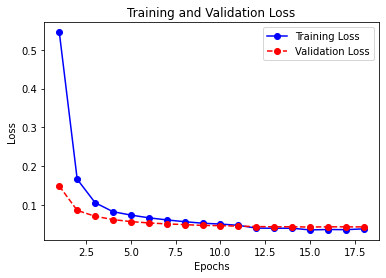

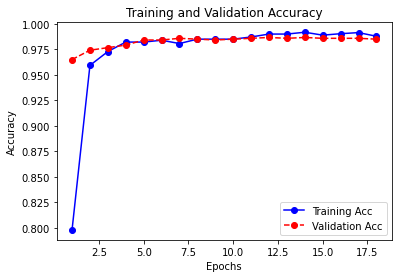

In [45]:
# 顯示訓練和驗證損失
loss = history.history["loss"]
epochs = range(1, len(loss)+1)
val_loss = history.history["val_loss"]
plt.plot(epochs, loss, "bo-", label="Training Loss")
plt.plot(epochs, val_loss, "ro--", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
# 顯示訓練和驗證準確度
acc = history.history["accuracy"]
epochs = range(1, len(acc)+1)
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo-", label="Training Acc")
plt.plot(epochs, val_acc, "ro--", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

(1, 175, 175, 3)


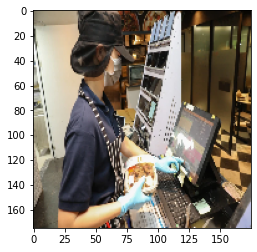

In [46]:
img = load_img("/content/drive/MyDrive/AI_共用/辨識是否為食物/photo.jpg", target_size=(175, 175))
plt.imshow(img)
x = img_to_array(img)
x = preprocess_input(x)
img = x.reshape(1,x.shape[0],x.shape[1],x.shape[2])
print(img.shape)

In [48]:
result = model.predict(img)
print(result)
maxindex = np.argmax(result)
print(maxindex)

[[0.988761   0.01215115]]
0
